# **Brain Tumor MRI Image Classification**

## **Project Type**- Classification

## **Contribution** - Individual

## **Name** - Janani Ravi

# **Project Summary** 

# **GitHub Link** - [Click here](https://github.com/Jan2309jr/Brain-Tumor-MRI-Image-Classification.git)

# **Problem Statement**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# **1. Understanding my Dataset**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import shutil
from tqdm import tqdm
import matplotlib.cm as cm
from PIL import Image
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D,TFSMLayer, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, ResNet50

2025-07-21 12:29:18.777870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753100958.980337      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753100959.045196      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the dataset

In [2]:
#setting paths
base_path="/kaggle/input/brain-tumor-trainingset/Brain-Tumor-Dataset"
train_path=os.path.join(base_path,"train")
test_path=os.path.join(base_path,"test")
valid_path=os.path.join(base_path,"valid")

## Number of categories(tumor types)

In [3]:
def categories(data_path):
    categories = []
    for i in os.listdir(data_path):
        if(os.path.isdir(os.path.join(data_path,i))):
            categories.append(i)
    return categories
print("Brain Tumor Dataset")
print(categories(base_path))
print("Train folder")
print(categories(train_path))

Brain Tumor Dataset
['valid', 'test', 'train']
Train folder
['pituitary', 'no_tumor', 'meningioma', 'glioma']


## First View of dataset

Training set image samples

 pituitary


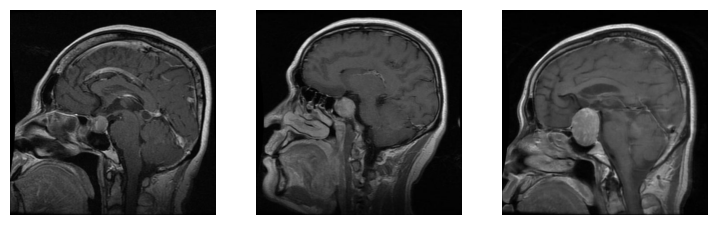


 no_tumor


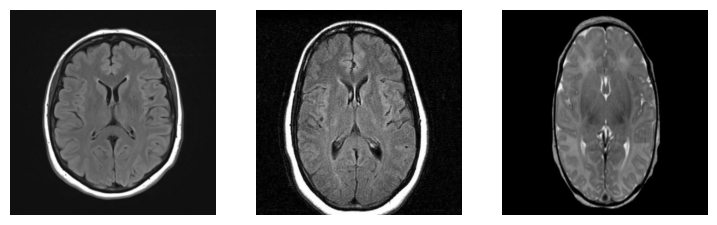


 meningioma


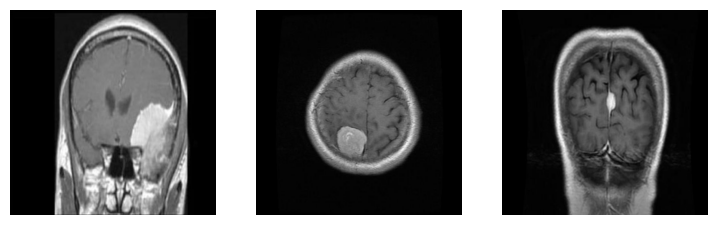


 glioma


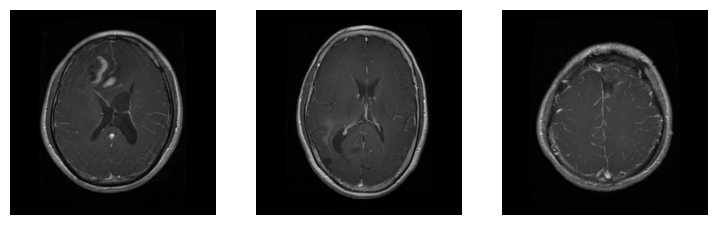

In [4]:
def show_sample_images(data_path,n=3):
    for i in os.listdir(data_path):
        cat_path=os.path.join(data_path,i)
        if(os.path.isdir(cat_path)):
            images=os.listdir(cat_path)[:3]
            plt.figure(figsize=(n*3,3))
            print("\n",i)
            for k,j in enumerate(images):
                img=Image.open(os.path.join(cat_path,j))
                plt.subplot(1,n,k+1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
print("Training set image samples")
show_sample_images(train_path)

## Dataset count in each category

In [5]:
def count_dataset(data_path):
    print(f"The dataset has {len(os.listdir(data_path))} folders: {os.listdir(data_path)} \n")
    print("-----------")
    for i in os.listdir(data_path):
        count_cat=0;
        print(f"{i} folder :-")
        if(os.path.isdir(os.path.join(data_path,i))):
            for j in os.listdir(os.path.join(data_path,i)):
                if(os.path.isdir(os.path.join(data_path,i,j))):
                    count_cat+=1
                    print(f"{j} : {len(os.listdir(os.path.join(data_path,i,j)))}")
        print("-----------")
        

count_dataset(base_path)

The dataset has 3 folders: ['valid', 'test', 'train'] 

-----------
valid folder :-
pituitary : 118
no_tumor : 99
meningioma : 124
glioma : 161
-----------
test folder :-
pituitary : 54
no_tumor : 49
meningioma : 63
glioma : 80
-----------
train folder :-
pituitary : 438
no_tumor : 335
meningioma : 358
glioma : 564
-----------


## Checking class imbalance visually in Training set

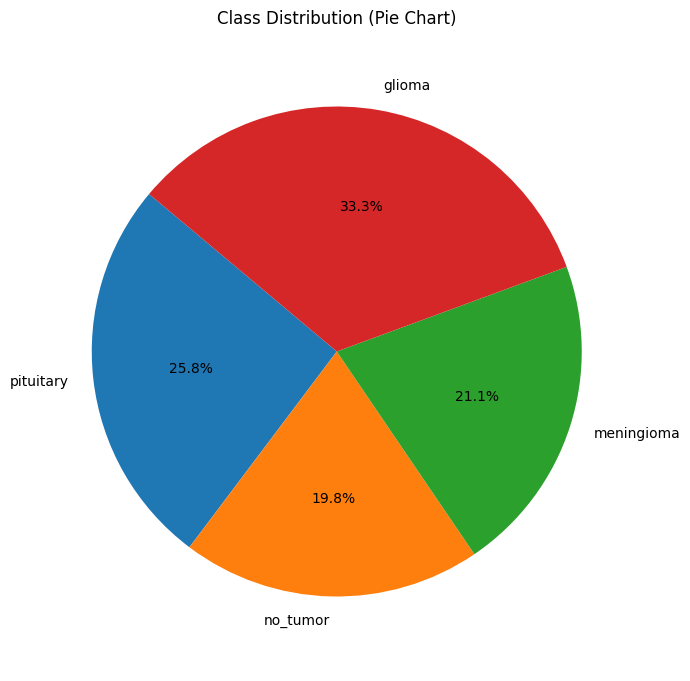

In [6]:
def class_distribution(data_path):
    class_count = {}

    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            class_count[class_name] = len(image_files)

    # Prepare data for pie chart
    labels = [*class_count.keys()]
    sizes = [*class_count.values()]

    # Plot pie chart
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140 )
    plt.title("Class Distribution (Pie Chart)")
    plt.axis('equal')  # Equal aspect ratio makes it a circle
    plt.tight_layout()
    plt.show()
class_distribution(train_path)

## Image resolution consistency


Unique Image Resolutions:
(640, 640): 1695 images


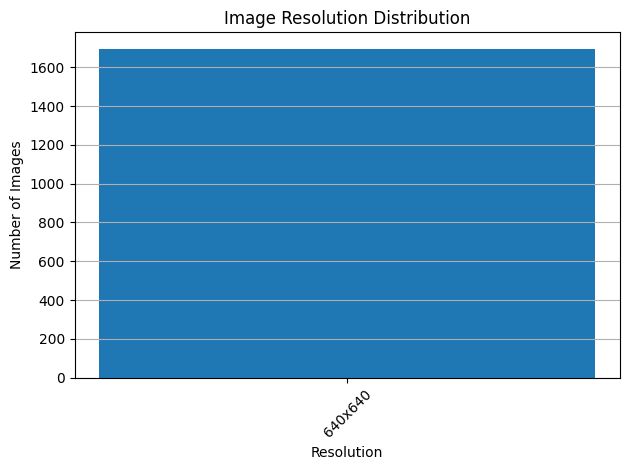

In [7]:
def check_image_resolutions(data_path):
    resolutions = {}

    for folder in os.listdir(data_path):
        path = os.path.join(data_path, folder)
        if not os.path.isdir(path):
            continue

        for file in os.listdir(path):
            try:
                img = Image.open(os.path.join(path, file))
                size = img.size  # (width, height)
                resolutions[size] = resolutions.get(size, 0) + 1
            except:
                print(f"Error reading {file}")

    print("\nUnique Image Resolutions:")
    for res, count in sorted(resolutions.items(), key=lambda x: -x[1]):
        print(f"{res}: {count} images")

    # Plot
    if resolutions:
        labels = [f"{w}x{h}" for (w, h) in resolutions.keys()]
        values = values = [v for v in resolutions.values()]

        plt.bar(labels, values)
        plt.title("Image Resolution Distribution")
        plt.xlabel("Resolution")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
check_image_resolutions(train_path)

## Exploratory Data Analysis

### Univariant Analysis

#### 1. Training Set Class Distribution Bar Graph

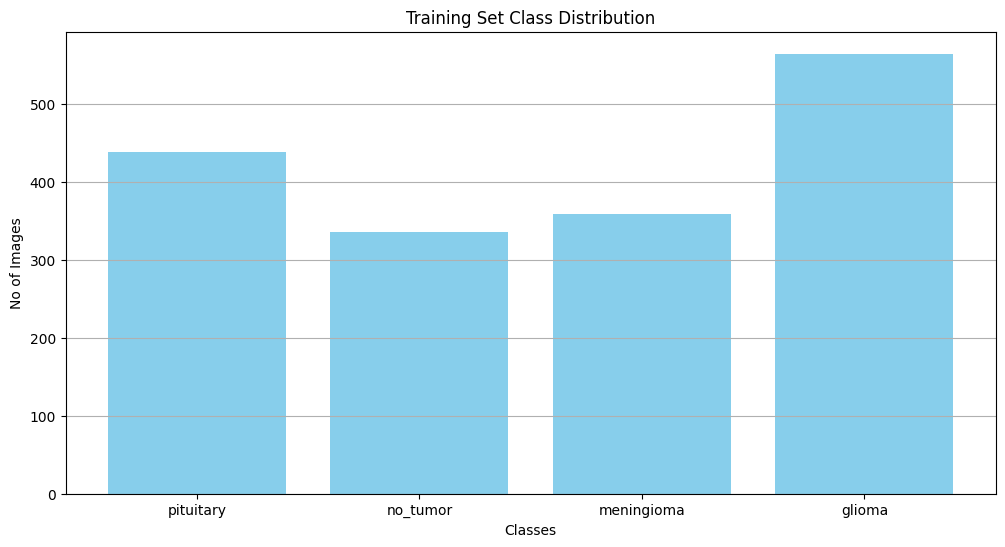

In [8]:
list1=[]
count=[]
for i in os.listdir(train_path):
    if(os.path.isdir(os.path.join(train_path,i))):
        list1.append(i)
        count.append(len(os.listdir(os.path.join(train_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list1,count,color="skyblue")
plt.title("Training Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 2. Test Set Class Distribution Bar Graph

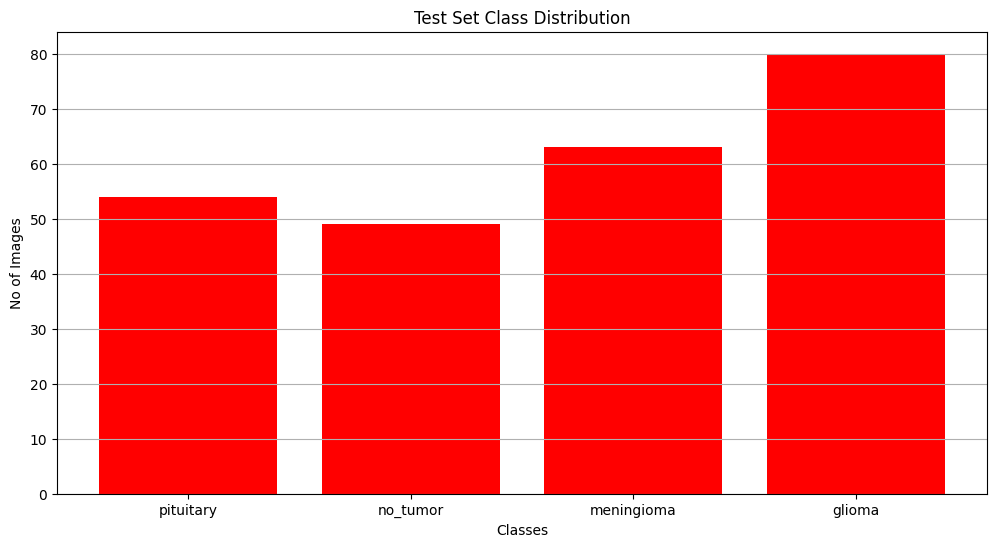

In [9]:
list2=[]
count=[]
for i in os.listdir(test_path):
    if(os.path.isdir(os.path.join(test_path,i))):
        list2.append(i)
        count.append(len(os.listdir(os.path.join(test_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list2,count,color="red")
plt.title("Test Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 3. Valid Set Class Distribution Bar Graph

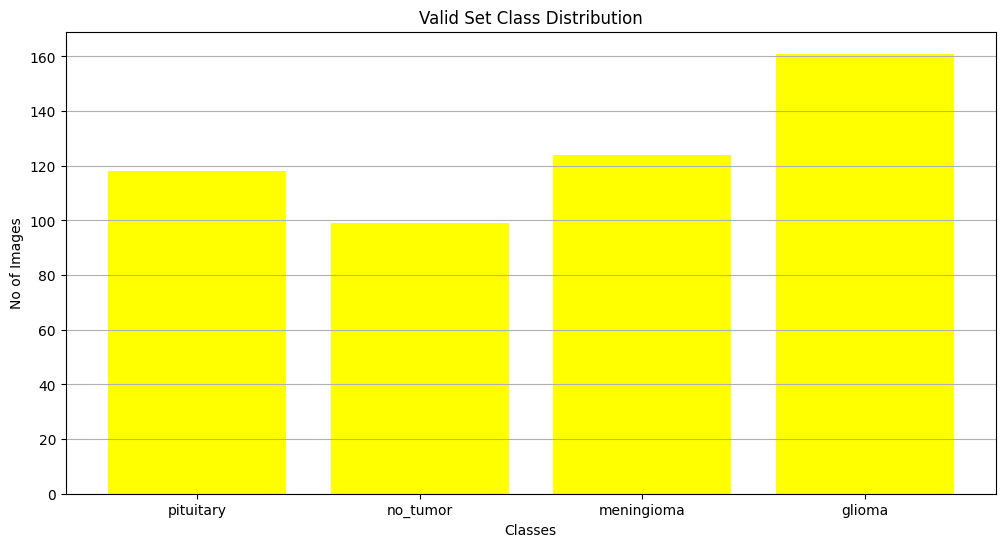

In [10]:
list3=[]
count=[]
for i in os.listdir(valid_path):
    if(os.path.isdir(os.path.join(valid_path,i))):
        list3.append(i)
        count.append(len(os.listdir(os.path.join(valid_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list3,count,color="yellow")
plt.title("Valid Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 4. Image Resolution Consistency Bar Graph

##### i. Training set


Unique Image Resolutions:
(640, 640): 1695 images


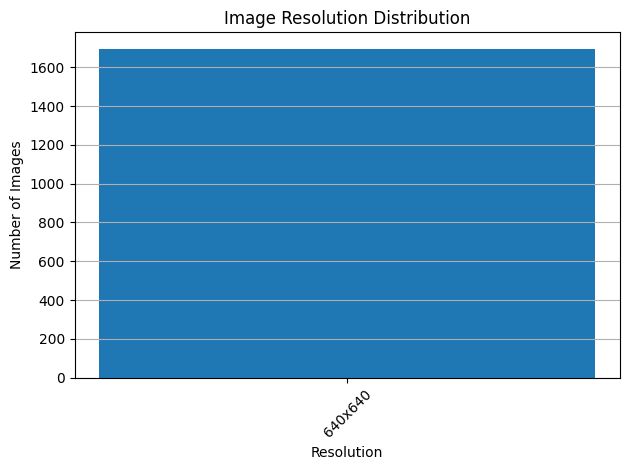

In [11]:
check_image_resolutions(train_path)

##### ii. Testing set


Unique Image Resolutions:
(640, 640): 246 images


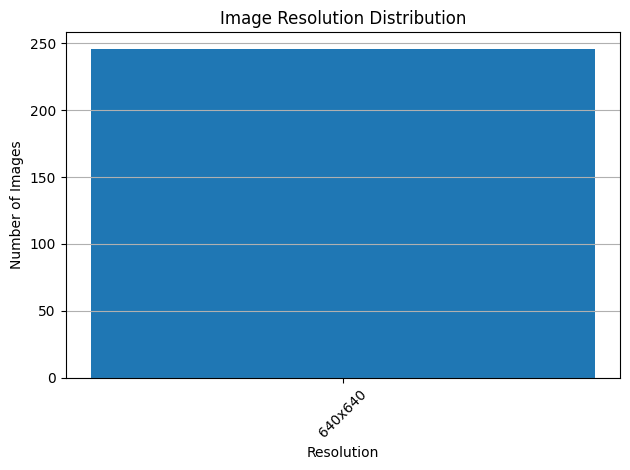

In [12]:
check_image_resolutions(test_path)

#### 3. Brightness distribution Histogram

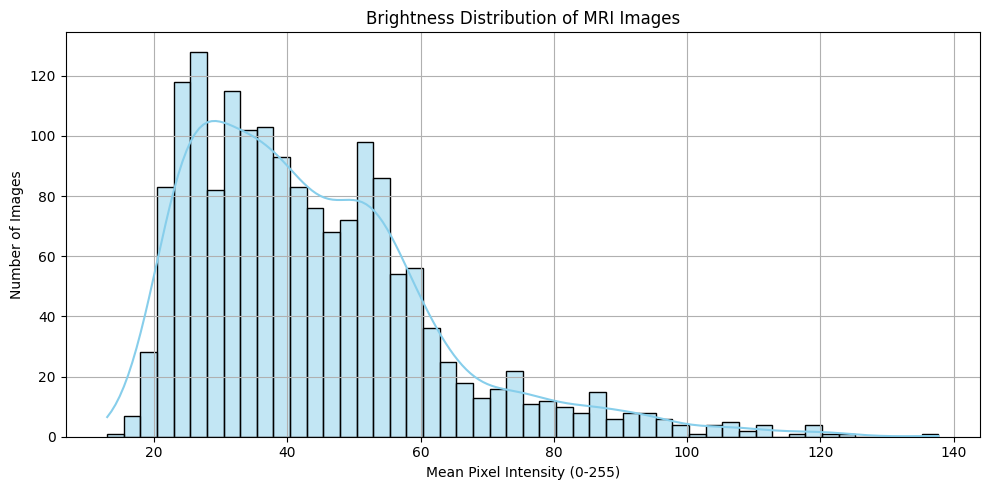

In [13]:
def brightness_dist(data_path):
    brightness_list = []
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    for i in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, i)):
            for j in os.listdir(os.path.join(data_path, i)):
                img = os.path.join(data_path, i, j)
                image = Image.open(img).convert("L")
                img_pix_list = np.array(image)
                mean_brightness = np.mean(img_pix_list)
                brightness_list.append(mean_brightness)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(brightness_list, bins=50, color='skyblue', kde=True)
    plt.title("Brightness Distribution of MRI Images")
    plt.xlabel("Mean Pixel Intensity (0-255)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
brightness_dist(train_path)

#### 4. Pixel Intensity Histogram

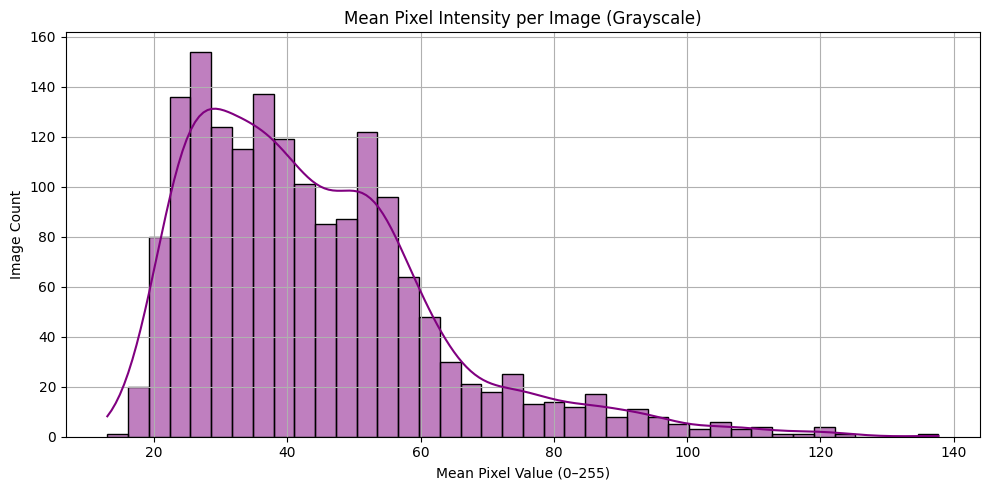

In [14]:
def pixel_intensity_per_image(data_path):
    mean_pixel_values = []

    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        if not os.path.isdir(class_path): continue

        for image_file in os.listdir(class_path):
            try:
                image_path = os.path.join(class_path, image_file)
                img = Image.open(image_path).convert("L")
                img_arr = np.array(img)
                mean_pixel_values.append(np.mean(img_arr))
            except:
                continue

    plt.figure(figsize=(10, 5))
    sns.histplot(mean_pixel_values, bins=40, kde=True, color="purple")
    plt.title("Mean Pixel Intensity per Image (Grayscale)")
    plt.xlabel("Mean Pixel Value (0–255)")
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
pixel_intensity_per_image(train_path)

### Bivariant Analysis

#### 5. Class Count across Folders

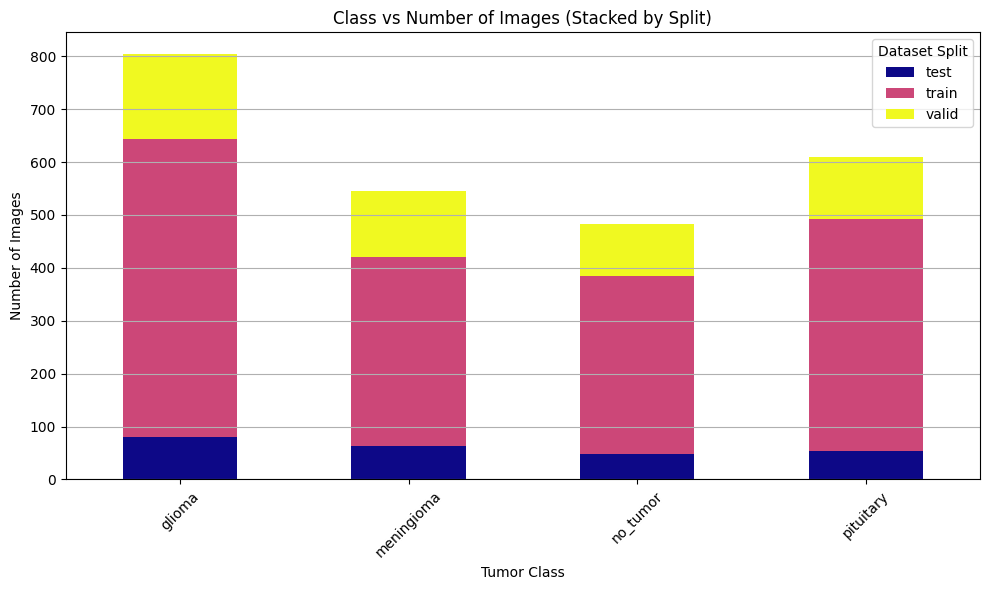

In [15]:
data = []

# Loop through splits and classes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path): continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path): continue  
        num_images = len(os.listdir(cls_path))
        data.append({"Class": cls, "Split": split, "ImageCount": num_images})

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot to wide format for stacked bar
pivot_df = df.pivot(index="Class", columns="Split", values="ImageCount").fillna(0)

# Plot stacked bar
pivot_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap='plasma')
plt.title("Class vs Number of Images (Stacked by Split)")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

#### 6. Class VS Pixel Intensity Boxplot

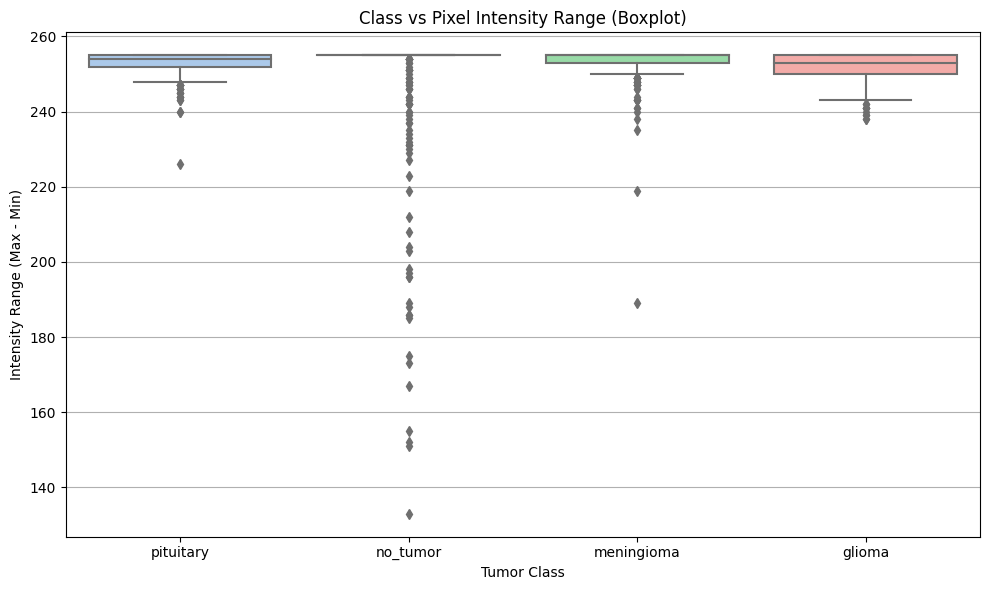

In [16]:
# Build DataFrame with intensity range
data = []
for i in os.listdir(train_path):
    if (os.path.isdir(os.path.join(train_path,i))):
        for j in os.listdir(os.path.join(train_path,i)):
            img=os.path.join(train_path,i,j)
            image=Image.open(img).convert("L")
            img_list=np.array(image)
            intensity_range=np.max(img_list)-np.min(img_list)
            data.append({"class": i, "intensity_range": intensity_range})

df = pd.DataFrame(data)

# Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='intensity_range', data=df, palette='pastel')
plt.title("Class vs Pixel Intensity Range (Boxplot)")
plt.ylabel("Intensity Range (Max - Min)")
plt.xlabel("Tumor Class")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 7. Class VS brigthness historgram

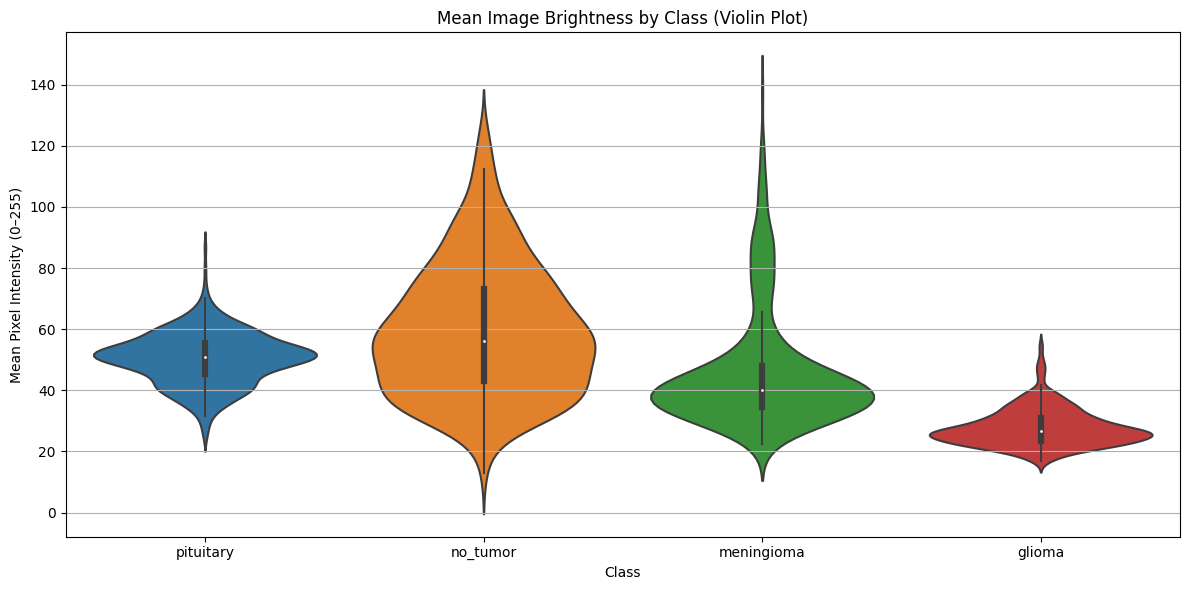

In [17]:
def class_vs_brightness_violin(data_path):
    records = []
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Collect brightness data with class labels
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert("L")
                    img_pix = np.array(image)
                    mean_brightness = np.mean(img_pix)
                    records.append({"Class": class_name, "Brightness": mean_brightness})
                except Exception as e:
                    continue

    # Create DataFrame for plotting
    df = pd.DataFrame(records)

    # Violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Class", y="Brightness", data=df, inner="box", scale="width")
    plt.title("Mean Image Brightness by Class (Violin Plot)")
    plt.xlabel("Class")
    plt.ylabel("Mean Pixel Intensity (0–255)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
class_vs_brightness_violin(train_path)

#### 8. Feature Correlation Heatmap

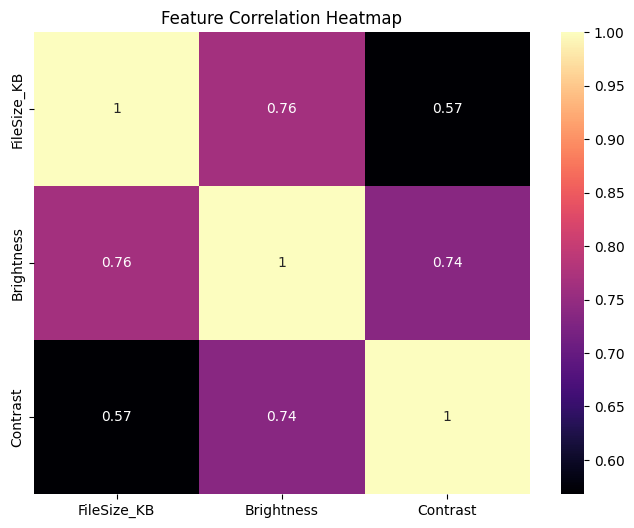

In [18]:
def build_feature_df(data_path):
    records = []
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert('L')
                    img_array = np.array(image)
                    width, height = image.size
                    file_size_kb = os.path.getsize(img_path)/1024
                    mean_brightness = np.mean(img_array)
                    contrast = np.std(img_array)
                    records.append({
                        'Class': class_name,
                        'Width': width,
                        'Height': height,
                        'FileSize_KB': file_size_kb,
                        'Brightness': mean_brightness,
                        'Contrast': contrast
                    })
                except Exception:
                    continue
    return pd.DataFrame(records)

# Build DataFrame from all images in the dataset
df = build_feature_df(train_path)
# Compute and plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['FileSize_KB', 'Brightness', 'Contrast']].corr(), annot=True , cmap="magma")
plt.title("Feature Correlation Heatmap")
plt.show()


# **2. Data Preprocessing**

## 1. Normalizing Pixel Values

In [19]:
# Create an instance of ImageDataGenerator with normalization (rescaling)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## 2. Resizing Images

In [20]:
print("Training set")
# Load images from directories using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # resize all images to 224x224
    batch_size=32,
    class_mode='categorical'  # since it's multi-class classification
)
print("Valid set")
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Testing set")
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # keep order for evaluation
)

Training set
Found 1695 images belonging to 4 classes.
Valid set
Found 502 images belonging to 4 classes.
Testing set
Found 246 images belonging to 4 classes.


In [21]:
#checking if normalized
batch_images, batch_labels = next(train_generator)
print(f"Min pixel value: {batch_images.min()}")
print(f"Max pixel value: {batch_images.max()}")

Min pixel value: 0.0
Max pixel value: 1.0


# **3. Data Augmentation**

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)
'''NOTE- not applying augmentation for test and valid set as they are suppose to be real world 
data with imperfections for the model to evaluate its efficiency '''
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # keep image order for accurate prediction analysis
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# **4. Model Building**

## Designing Custom CNN

In [23]:
model_customCNN = Sequential()

model_customCNN.add(Input(shape=(224, 224, 3)))

# Block 1
model_customCNN.add(Conv2D(32, (3, 3), activation='relu'))
model_customCNN.add(BatchNormalization())
model_customCNN.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_customCNN.add(Conv2D(64, (3, 3), activation='relu'))
model_customCNN.add(BatchNormalization())
model_customCNN.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_customCNN.add(Conv2D(128, (3, 3), activation='relu'))
model_customCNN.add(BatchNormalization())
model_customCNN.add(MaxPooling2D(pool_size=(2, 2)))
model_customCNN.add(Dropout(0.25))

# Block 4
model_customCNN.add(Conv2D(256, (3, 3), activation='relu'))
model_customCNN.add(BatchNormalization())
model_customCNN.add(MaxPooling2D(pool_size=(2, 2)))
model_customCNN.add(Dropout(0.25))

# Flatten + Dense
model_customCNN.add(Flatten())
model_customCNN.add(Dense(512, activation='relu'))
model_customCNN.add(Dropout(0.5))

# Output layer for 4 classes
model_customCNN.add(Dense(4, activation='softmax'))

# Compile
model_customCNN.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model_customCNN.summary()

I0000 00:00:1753101014.194241      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,268 (73.50 MB)

 Trainable params: 19,266,308 (73.50 MB)

 Non-trainable params: 960 (3.75 KB)

# 5. Transfer Learning

In [24]:
def build_transfer_model(base_model, num_classes=4, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

## 1. EfficientNetB0

In [25]:
# Load EfficientNetB0 without pretrained weights (random init)
base_model_EfficientNetB0 = EfficientNetB0(include_top=False, weights=None, input_shape=(224, 224, 3))

# Freeze base model layers if needed
base_model_EfficientNetB0.trainable = False  # Set True if you want to fine-tune

# Build full model
model_EfficientNetB0 = build_transfer_model(base_model_EfficientNetB0, num_classes=4)

# Compile
model_EfficientNetB0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
model_EfficientNetB0.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 660,484 (2.52 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## 2. InceptionV3

In [26]:
# ✅ Load InceptionV3 base model without pre-trained weights
base_model_InceptionV3 = InceptionV3(include_top=False, weights=None, input_shape=(224, 224, 3))

# Freeze base model layers (optional)
base_model_InceptionV3.trainable = False  # Set to True if fine-tuning

# 🔧 Build full transfer learning model
model_InceptionV3 = build_transfer_model(base_model_InceptionV3, num_classes=4)

# ⚙️ Compile the model
model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📋 Summary
model_InceptionV3.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,862,116 (87.21 MB)

 Trainable params: 1,055,236 (4.03 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

## 3. ResNet50

In [27]:
# Load ResNet50 without pretrained weights (random init)
base_model_RestNo50 = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))

# Freeze base model layers if needed
base_model_RestNo50.trainable = False  # Set to True to fine-tune

# Build and compile the full model
model_RestNo50 = build_transfer_model(base_model_RestNo50, num_classes=4)

model_RestNo50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
model_RestNo50.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,647,044 (94.02 MB)

 Trainable params: 1,055,236 (4.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

# 6. Model Training

## 1. Training Model

In [28]:
# EarlyStopping callback: Stop training if val_loss doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',       # What to monitor
    patience=3,               # How many epochs to wait before stopping
    restore_best_weights=True, # Restore weights of best val_loss
    verbose=1
)

# ModelCheckpoint callback: Save model only when val_loss improves
def checkpoint_cb(model_name):
    return ModelCheckpoint(
        filepath=f"/kaggle/working/{model_name}_best_model.keras",  # Save path
        monitor='val_loss',              # Metric to monitor
        save_best_only=True,            # Save only the best model
        verbose=1                       # Print when a model is saved
    )

In [29]:
warnings.filterwarnings("ignore", category=UserWarning)
histories = {}
models = {
    "CustomCNN": model_customCNN,
    "EfficientNetB0": model_EfficientNetB0,
    "InceptionV3": model_InceptionV3,
    "RestNo50": model_RestNo50
}

for name, model in models.items():
    print(f"\n Training {name}")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=20,
        callbacks=[early_stop, checkpoint_cb(name)],
        verbose=1
    )
    histories[name] = history



 Training CustomCNN
Epoch 1/20


I0000 00:00:1753101026.076534     104 service.cc:148] XLA service 0x7f78e8003360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753101026.077235     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753101026.772356     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/53 ━━━━━━━━━━━━━━━━━━━━ 10:41 12s/step - accuracy: 0.2812 - loss: 3.4262

I0000 00:00:1753101033.273624     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5184 - loss: 2.9283
Epoch 1: val_loss improved from inf to 5.93971, saving model to /kaggle/working/CustomCNN_best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 635ms/step - accuracy: 0.5199 - loss: 2.9118 - val_accuracy: 0.3207 - val_loss: 5.9397
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6896 - loss: 0.8327
Epoch 2: val_loss did not improve from 5.93971
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.6899 - loss: 0.8317 - val_accuracy: 0.3207 - val_loss: 8.5116
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7330 - loss: 0.6862
Epoch 3: val_loss did not improve from 5.93971
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.7332 - loss: 0.6863 - val_accuracy: 0.3207 - val_loss: 10.4535
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7717 - loss: 0.6583
Epoch 4: val_loss did not improve from 5.93971
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.7719 - l

## 2. Tracking training and validation metrics

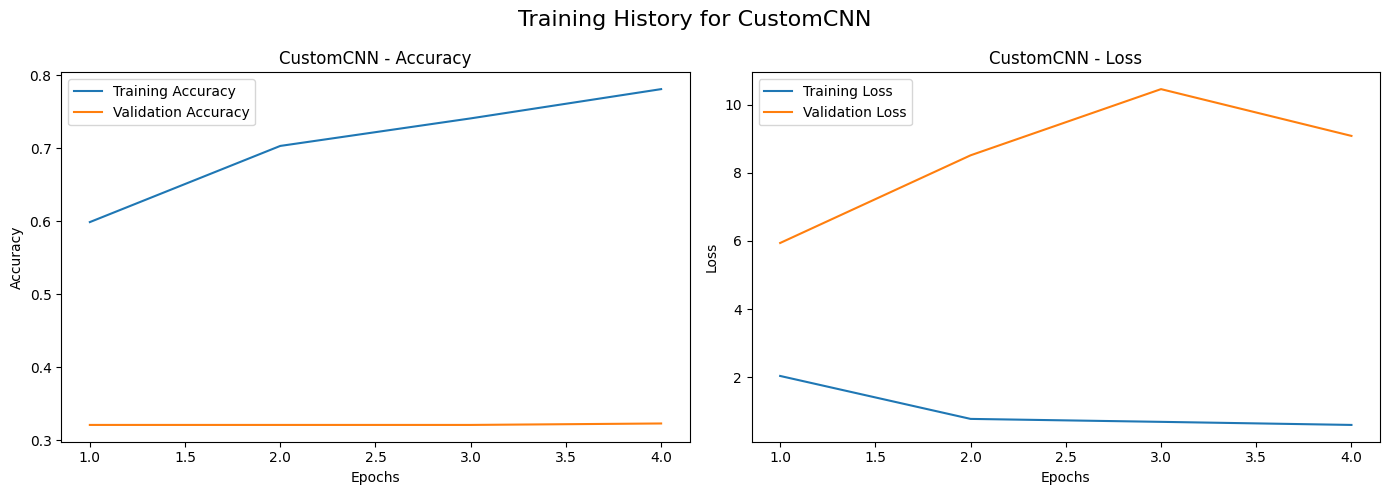

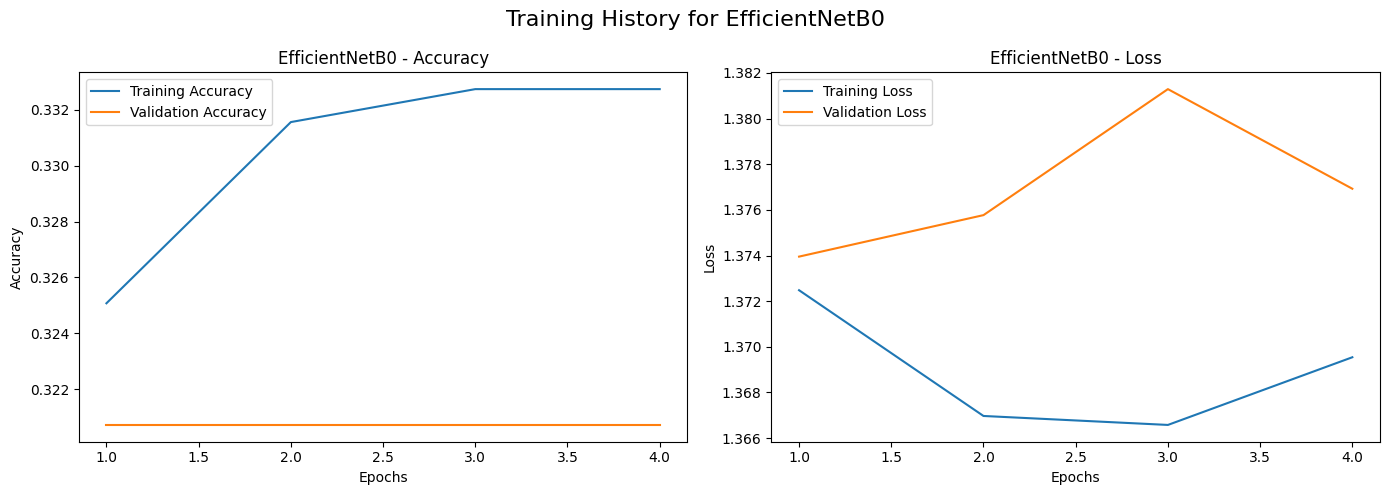

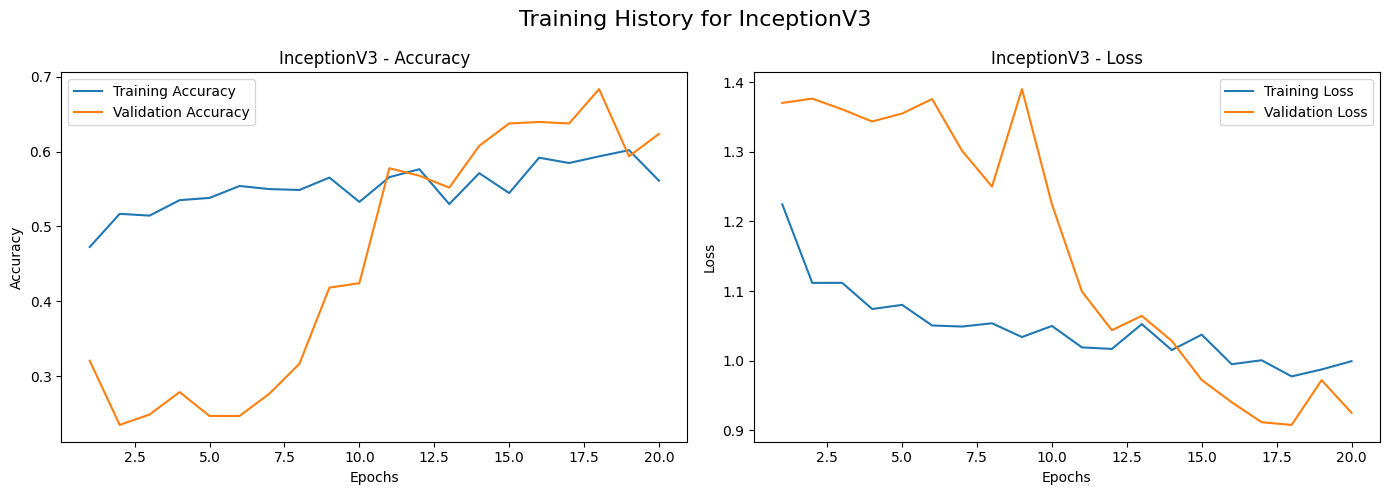

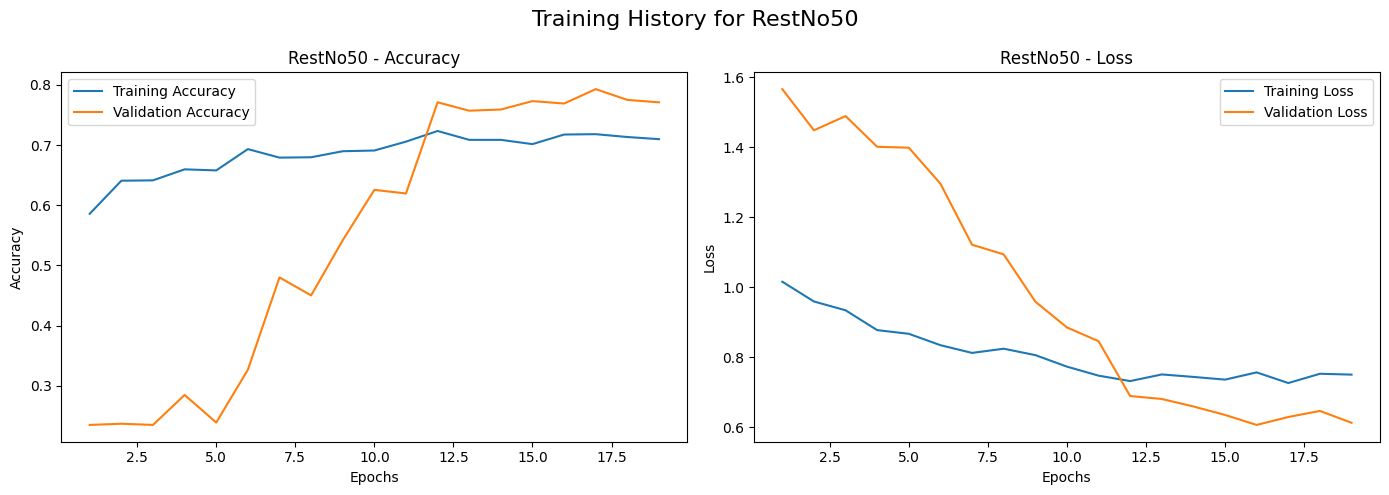

In [30]:
def plot_training_history(histories):
    for model_name, history in histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        plt.figure(figsize=(14, 5))
        
        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.suptitle(f"Training History for {model_name}", fontsize=16)
        plt.tight_layout()
        plt.show()
plot_training_history(histories)

# 7. Model Evaluation

## 1. Evaluating Model Using :

* Accuracy Score
* Precision Score
* Recall Score
* F1 Score
* Confusion Matrix

In [31]:
def evaluate_model(model, valid_generator, class_names, model_name="Model"):
    print("-----------------------------")
    print(f"\n Evaluating: {model_name}")
    
    # Get true labels
    true_labels = valid_generator.classes
    
    # Get predicted probabilities
    pred_probs = model.predict(valid_generator, verbose=1)
    
    # Get predicted class indices
    pred_labels = np.argmax(pred_probs, axis=1)
    
    # Accuracy
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    
    # Classification Report
    print(f"\n Classification Report:\n{classification_report(true_labels, pred_labels, target_names=class_names)}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

-----------------------------

 Evaluating: CustomCNN
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.32      1.00      0.49       161
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.00      0.00      0.00        99
   pituitary       0.00      0.00      0.00       118

    accuracy                           0.32       502
   macro avg       0.08      0.25      0.12       502
weighted avg       0.10      0.32      0.16       502



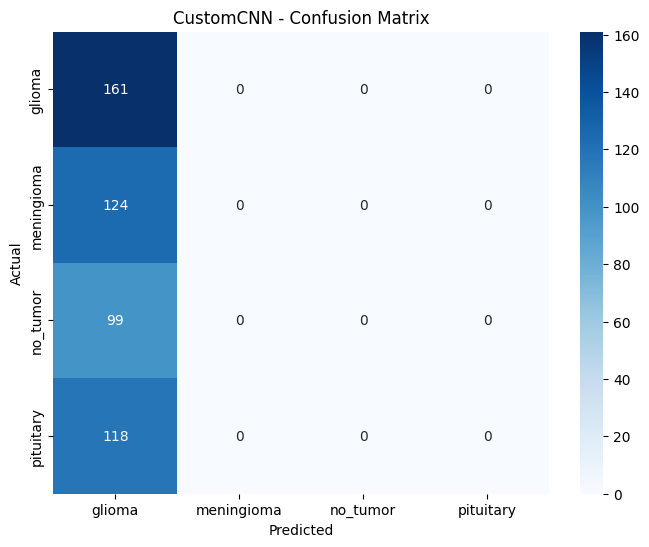

-----------------------------

 Evaluating: EfficientNetB0
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 566ms/step

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.32      1.00      0.49       161
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.00      0.00      0.00        99
   pituitary       0.00      0.00      0.00       118

    accuracy                           0.32       502
   macro avg       0.08      0.25      0.12       502
weighted avg       0.10      0.32      0.16       502



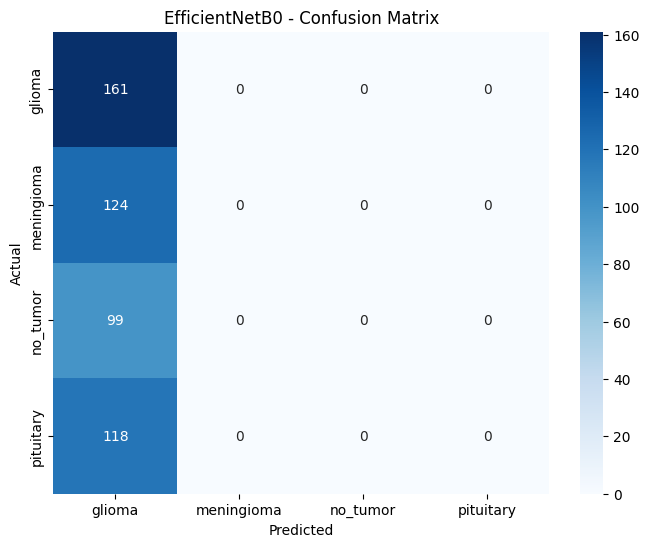

-----------------------------

 Evaluating: InceptionV3
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.34      0.38      0.36       161
  meningioma       0.28      0.21      0.24       124
    no_tumor       0.21      0.16      0.18        99
   pituitary       0.28      0.37      0.32       118

    accuracy                           0.29       502
   macro avg       0.28      0.28      0.28       502
weighted avg       0.29      0.29      0.29       502



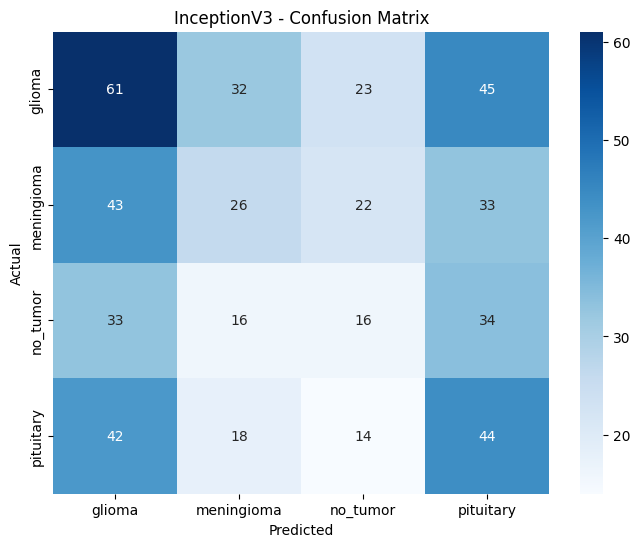

-----------------------------

 Evaluating: RestNo50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.32      0.32      0.32       161
  meningioma       0.27      0.23      0.25       124
    no_tumor       0.20      0.18      0.19        99
   pituitary       0.23      0.28      0.25       118

    accuracy                           0.26       502
   macro avg       0.25      0.25      0.25       502
weighted avg       0.26      0.26      0.26       502



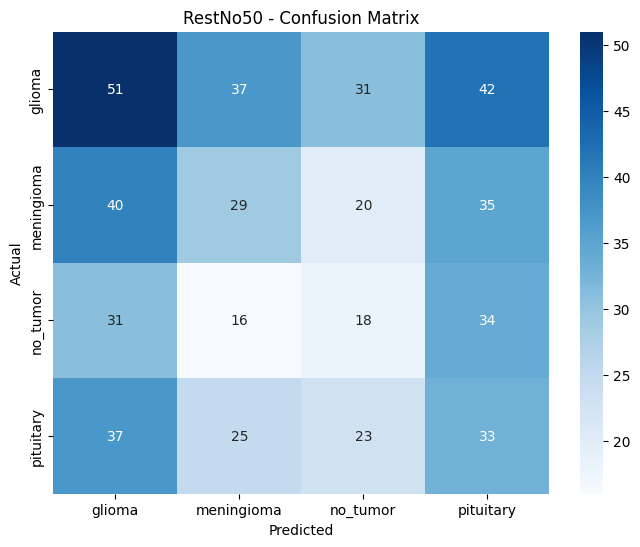

In [32]:
class_names = list(valid_generator.class_indices.keys())
results = {}

for name, model in models.items():
    model.load_weights(f"/kaggle/working/{name}_best_model.keras")  # load best checkpoint
    results[name] = evaluate_model(model, valid_generator, class_names, name)

In [33]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("\n Model Performance Comparison:")
display(results_df)


 Model Performance Comparison:


,accuracy,precision,recall,f1_score
CustomCNN,0.3207,0.1029,0.3207,0.1558
EfficientNetB0,0.3207,0.1029,0.3207,0.1558
InceptionV3,0.2928,0.2875,0.2928,0.2863
RestNo50,0.2610,0.2623,0.2610,0.2606


# 8. Model Comparison

## 1.  Evaluating Each Model Based on the Test Set


 Evaluation Results for: CustomCNN
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
              precision    recall  f1-score   support

      glioma       0.32      1.00      0.49       161
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.00      0.00      0.00        99
   pituitary       0.00      0.00      0.00       118

    accuracy                           0.32       502
   macro avg       0.08      0.25      0.12       502
weighted avg       0.10      0.32      0.16       502



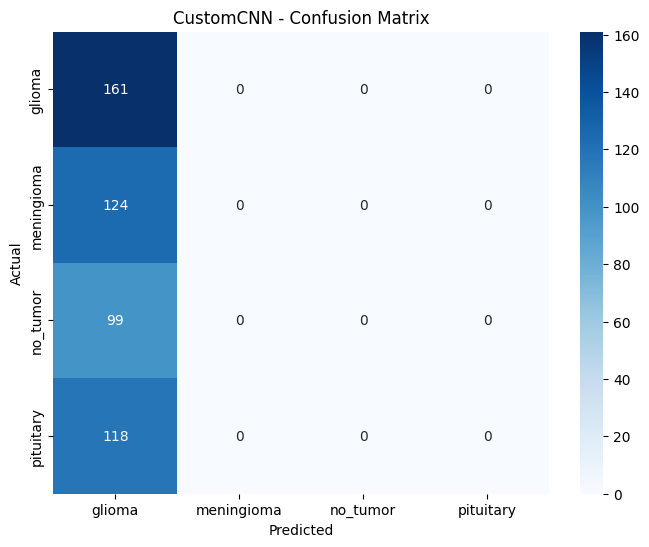


 Evaluation Results for: EfficientNetB0
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
              precision    recall  f1-score   support

      glioma       0.32      1.00      0.49       161
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.00      0.00      0.00        99
   pituitary       0.00      0.00      0.00       118

    accuracy                           0.32       502
   macro avg       0.08      0.25      0.12       502
weighted avg       0.10      0.32      0.16       502



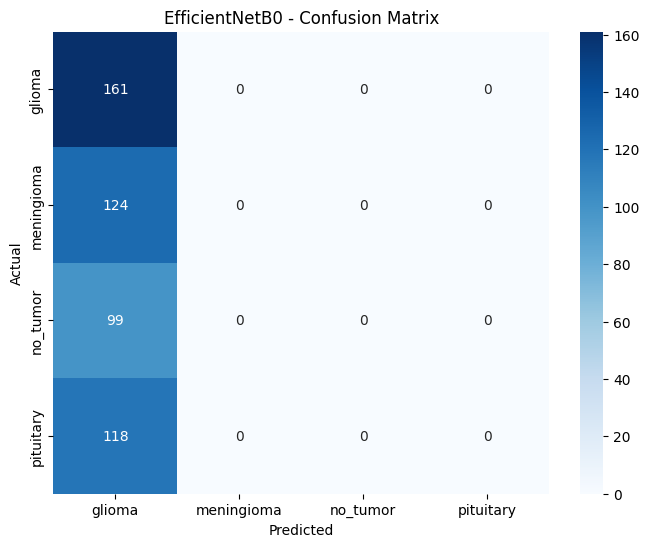


 Evaluation Results for: InceptionV3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
              precision    recall  f1-score   support

      glioma       0.36      0.40      0.38       161
  meningioma       0.25      0.19      0.21       124
    no_tumor       0.24      0.18      0.21        99
   pituitary       0.24      0.32      0.28       118

    accuracy                           0.28       502
   macro avg       0.27      0.27      0.27       502
weighted avg       0.28      0.28      0.28       502



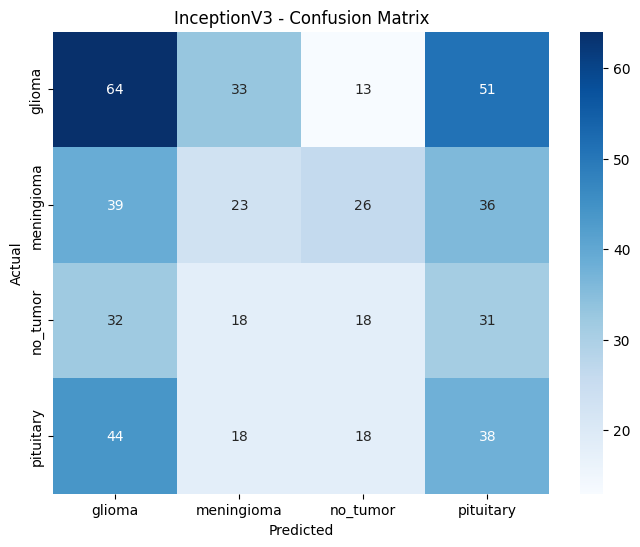


 Evaluation Results for: RestNo50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
              precision    recall  f1-score   support

      glioma       0.28      0.27      0.27       161
  meningioma       0.21      0.19      0.20       124
    no_tumor       0.25      0.23      0.24        99
   pituitary       0.26      0.32      0.29       118

    accuracy                           0.25       502
   macro avg       0.25      0.25      0.25       502
weighted avg       0.25      0.25      0.25       502



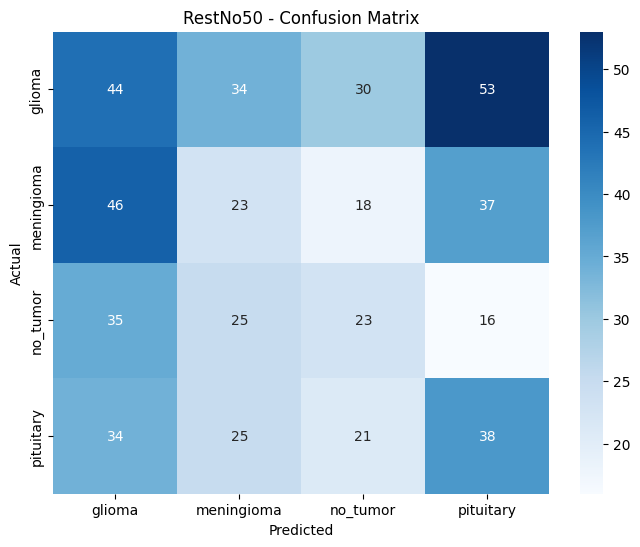

In [34]:
def evaluate_model(name, model, test_generator):
    print(f"\n Evaluation Results for: {name}")
    
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
for name, model in models.items():
    evaluate_model(name, model, valid_generator)


## 2. Metric Summary

In [35]:
def get_metrics(model, test_generator):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-score": f1_score(y_true, y_pred, average='weighted')
    }

# Collect results
results = {}
for name, model in models.items():
    results[name] = get_metrics(model, valid_generator)

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
results_df

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


,Accuracy,Precision,Recall,F1-score
CustomCNN,0.3207,0.1029,0.3207,0.1558
EfficientNetB0,0.3207,0.1029,0.3207,0.1558
InceptionV3,0.2789,0.2786,0.2789,0.2750
RestNo50,0.2390,0.2357,0.2390,0.2365


## 3. Visualization of the Comparison 

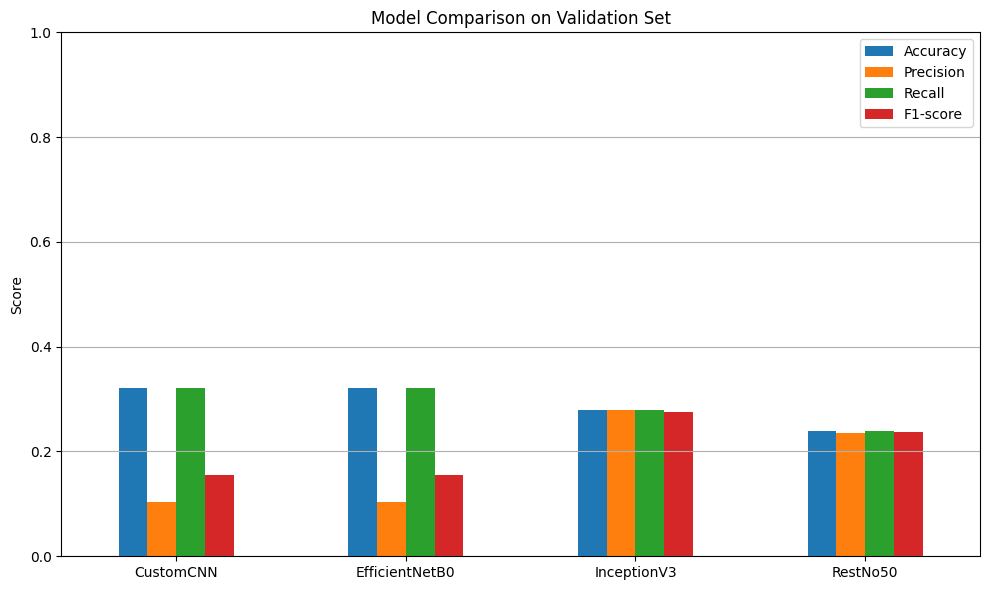

In [36]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()